# Implementing Energy Function

In [1]:
import xml.etree.ElementTree as ET
from math import tanh
from pathlib import Path
from collections import defaultdict

import numpy as np

from idpconfgen.libs.libstructure import Structure, col_element

## Preparating Structures and Parameters

### Loading structures

Here we will load two conformers, one with clashes and other with clashes that were created by the current version of `IDPConfGen`. Clashes were computed with a simple hard sphere clash optimization. We will use `Structure()` to extract the coordinates and labels of the conformers. Keep in mind that, when during the building process, coordinates and labels will be already in memory.

In [2]:
good = Path('conformer_good.pdb')
bad = Path('conformer_bad.pdb')

In [3]:
# good
gs = Structure(good)
gs.build()
gcoods = gs.coords

# bad
bs = Structure(bad)
bs.build()
bcoods = bs.coords

# both good and bad are equal in terms of atoms and labels
elements = gs.data_array[:, col_element]
print(elements[:5])

['N' 'C' 'C' 'O' 'C']


### Loading parameters from Force Fields

This is a crucial part as parameters need to be in tune with each other.

I will build the parameters here as I implement the different energy functions.

In [4]:
with open('../data/protein.ff14SB.xml', 'r') as fin:
    ff14SB = ET.fromstring(fin.read())

In [5]:
forcefield_params = defaultdict(dict)
for atom in ff14SB[-1][1:]:
    
    # simplistic approach using only element
    atom_type = atom.attrib['type'].split('-')[-1]
    
    forcefield_params[atom_type]['epsilon'] = float(atom.attrib['epsilon'])
    forcefield_params[atom_type]['sigma'] = float(atom.attrib['sigma'])

In [6]:
forcefield_params.keys()

dict_keys(['C', 'CA', 'CB', 'CC', 'CN', 'CR', 'CT', 'CV', 'CW', 'C*', 'CX', 'H', 'HC', 'H1', 'HA', 'H4', 'H5', 'HO', 'HS', 'HP', 'N', 'NA', 'NB', 'N2', 'N3', 'O', 'O2', 'OH', 'S', 'SH', 'CO', '2C', '3C', 'C8'])

In [7]:
forcefield_params['C']

{'epsilon': 0.359824, 'sigma': 0.3399669508423535}

### Prepares data arrays

Prepares data before performing calculations, in order to allow for parameters indexing.

In [8]:
epsilons = np.array([
    forcefield_params[element]['epsilon']
    for element in elements
    ])
print(epsilons[:5])

[0.71128  0.359824 0.359824 0.87864  0.359824]


In [9]:
r_min = np.array([
    (2 * forcefield_params[element]['sigma'])**(1/6)
    for element in elements
    ])
print(r_min[:5])

[0.9307196  0.93772994 0.93772994 0.91632958 0.93772994]


## Defining Energy Terms

... and implementation

### vdW term

$$
E_{vdW} = 
\begin{cases}
      \infty, \qquad\qquad\qquad\qquad\qquad\quad r_{ij} < r_{ij}^{*} \\
      4\varepsilon_{ij}\left[\left(\cfrac{\sigma_{ij}}{r_{ij}}\right)^{12} - \left(\cfrac{\sigma_{ij}}{r_{ij}}\right)^{6}\right], \qquad r_{ij} > r_{ij}^{*}
    \end{cases}
$$

Alternatively,

$$
E_{VDW} = \cfrac{ACOEFF}{r^{12}_{ij}} - \cfrac{BCOEFF}{r^{6}_{ij}}
$$

For this we can compute first-hand the $ACOEFF$ and $BCOEFF$, and rewrite the equation such that:

$$
ACOEFF = \varepsilon_{ij} r^{12}_{0} \\
BCOEFF = 2\varepsilon_{ij} r^{6}_{0} \\
\varepsilon_{ij} = \sqrt{\varepsilon_{i}\varepsilon_{j}} \\
r_{0} = r^{min}_{i} + r^{min}_{j} \\
r^{min}_{i} = \sqrt[6]{2\sigma_{i}} \\
r^{min}_{j} = \sqrt[6]{2\sigma_{j}} \\
r^{*}_{ij} = \alpha (r_{i} + r_{j}), \quad \alpha = 0.8
$$

#### Precomputing ACOEFF and BCOEFF

$\sigma$ and $\varepsilon$ values are as extracted from the `protein.ff14SB.xml`.

In [10]:
def calc_e_ij(epsilons):
    """Calculate epsilon for ij pair."""
    indices = np.triu_indices(epsilons.size, k=+1)    
    result = np.sqrt(np.outer(epsilons, epsilons)[indices])
    assert result.size == (epsilons.size * epsilons.size - epsilons.size) // 2
    return result

In [11]:
epsilons_ij = calc_e_ij(epsilons)
epsilons_ij

array([0.5059008 , 0.5059008 , 0.79054352, ..., 0.0656888 , 0.24024323,
       0.24024323])

In [12]:
def calc_r0(rmin):
    """Calculates the r0 for all atom pairs."""
    indices = np.triu_indices(rmin.size, k=+1)
    result = (rmin[:, None] + rmin)[indices]
    _expected_size = (rmin.size * rmin.size - rmin.size) // 2
    assert result.size == _expected_size, (result.size, _expected_size)
    return result

In [13]:
r0 = calc_r0(r_min)
print(r0[:5])

[1.86844954 1.86844954 1.84704918 1.86844954 1.70400521]


# General Python Tests

In [14]:
a  = np.char.array(list('abcd'))
print(a[:,None]+a)

[['aa' 'ab' 'ac' 'ad']
 ['ba' 'bb' 'bc' 'bd']
 ['ca' 'cb' 'cc' 'cd']
 ['da' 'db' 'dc' 'dd']]


In [15]:
a

chararray(['a', 'b', 'c', 'd'], dtype='<U1')

In [16]:
a[:,None]+a

chararray([['aa', 'ab', 'ac', 'ad'],
           ['ba', 'bb', 'bc', 'bd'],
           ['ca', 'cb', 'cc', 'cd'],
           ['da', 'db', 'dc', 'dd']], dtype='<U2')

In [17]:
b = np.arange(9)
b
il2 = np.triu_indices(9, k=1)

In [18]:
(b[:, None]+b)[il2]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  3,  4,  5,  6,  7,  8,  9,  5,  6,
        7,  8,  9, 10,  7,  8,  9, 10, 11,  9, 10, 11, 12, 11, 12, 13, 13,
       14, 15])

In [19]:
il1 = np.triu_indices(4, k=+1)

In [20]:
a = np.arange(16).reshape(4, 4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [21]:
a[il1]

array([ 1,  2,  3,  6,  7, 11])

# Testing some values of the force field

In [29]:
pi = 1.7
ppi = pi - 0.09
a = 0.8
b = 0
g = 2.91

I = np.linspace(0, 1, num=50)
Y = I*ppi

eq = (ppi**-1 - pi**-1 * np.tanh(a*Y - b*Y**2 + g*Y**3))**(-1)
eq2 = (ppi**-1 - pi**-1 * np.tanh(1*Y - 0.8*Y**2 + 4.85*Y**3))**(-1)

In [30]:
from matplotlib import pyplot as plt

%matplotlib inline

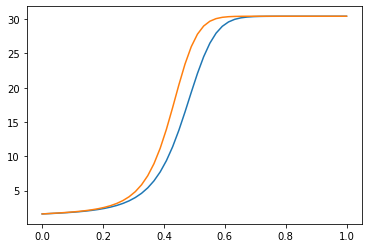

In [31]:
plt.plot(I, eq)
plt.plot(I, eq2)